In [103]:
import torch 
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor,Resize,Normalize
from  torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np
import os
from torch.utils.data import DataLoader
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import matplotlib.pyplot as plt

In [104]:
transforms={'Train_dir':transforms.Compose([Resize((244,244)),ToTensor(),Normalize([.485,.456 ,.406],[.229,.224,.224])]),
            'Val_dir' : transforms.Compose([Resize((244,244)),ToTensor(),Normalize([.485,.456 ,.406],[.229,.224,.224])])}

In [105]:
train_data = {x: ImageFolder(os.path.join('/Users/arpithvijaywargiya/Desktop/pytroch/insta_download', x),
                                          transforms[x])
                  for x in ['Train_dir', 'Val_dir']}
                  
#train_data=ImageFolder(root=os.path.join('/Users/arpithvijaywargiya/Desktop/pytroch/insta_download','Train_dir'),
#                      transform=transforms)

In [106]:
train_data['Train_dir'].classes

['Ankit', 'Arpit', 'cats', 'dogs']

In [107]:
len(train_data)

2

In [108]:
train_data.class_to_idx

AttributeError: 'dict' object has no attribute 'class_to_idx'

In [109]:
train_data[0][0]

KeyError: 0

In [110]:


dataloaders = {x: DataLoader(train_data[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Train_dir', 'Val_dir']}
               
               
#dataloader=DataLoader(train_data,shuffle=True,num_workers=4,batch_size=4)

In [118]:
dataset_sizes = {x: len(train_data[x]) for x in ['Train_dir', 'Val_dir']}
class_names = train_data['Train_dir'].classes

In [119]:
# pretrained network 

In [120]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train_dir','Val_dir']:
            if phase == 'Train_dir':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train_dir'):
                    outputs = model(inputs)
                    #print (outputs)
                    _, preds = torch.max(outputs, 1)
                    #print (preds)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train_dir':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train_dir':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val_dir' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [121]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [131]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [123]:
torch.__version__

'1.3.1'

In [132]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs = 5 )

Epoch 0/4
----------
Train_dir Loss: 0.8174 Acc: 0.6771
Val_dir Loss: 0.3516 Acc: 0.9412

Epoch 1/4
----------
Train_dir Loss: 0.4499 Acc: 0.8213
Val_dir Loss: 0.2914 Acc: 0.8235

Epoch 2/4
----------
Train_dir Loss: 0.3927 Acc: 0.8715
Val_dir Loss: 0.5014 Acc: 0.8235

Epoch 3/4
----------
Train_dir Loss: 0.3217 Acc: 0.8746
Val_dir Loss: 0.7370 Acc: 0.7647

Epoch 4/4
----------
Train_dir Loss: 0.3490 Acc: 0.8840
Val_dir Loss: 0.4106 Acc: 0.8235

Training complete in 7m 12s
Best val Acc: 0.941176


In [133]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [139]:
test_data = {x: ImageFolder(os.path.join('/Users/arpithvijaywargiya/Desktop/pytroch/insta_download', x),
                                          transforms[x])
                  for x in ['Train_dir', 'Val_dir']}
                  
#train_data=ImageFolder(root=os.path.join('/Users/arpithvijaywargiya/Desktop/pytroch/insta_download','Train_dir'),
#                      transform=transforms)

In [140]:


dataloaders_1 = {x: DataLoader(test_data[x], batch_size=15,
                                             shuffle=True, num_workers=1)
              for x in ['Train_dir', 'Val_dir']}
               
               
#dataloader=DataLoader(train_data,shuffle=True,num_workers=4,batch_size=4)

In [141]:
for i in dataloaders_1['Val_dir'].dataset:
    print (i)

(tensor([[[ 1.2214,  1.2214,  1.2043,  ...,  1.2214,  1.2214,  1.2043],
         [ 1.2214,  1.2214,  1.2385,  ...,  1.1872,  1.2214,  1.2385],
         [ 1.2043,  1.2385,  1.2728,  ...,  1.2214,  1.2557,  1.2728],
         ...,
         [ 0.3138,  0.2624,  0.1768,  ..., -0.1657, -0.1314, -0.0972],
         [ 0.3481,  0.2967,  0.1083,  ..., -0.1657, -0.1486, -0.1314],
         [ 0.3481,  0.2796,  0.1083,  ..., -0.1657, -0.1657, -0.1143]],

        [[ 1.3606,  1.3606,  1.3431,  ...,  1.3606,  1.3782,  1.3782],
         [ 1.3606,  1.3606,  1.3782,  ...,  1.3256,  1.3782,  1.4132],
         [ 1.3431,  1.3782,  1.4132,  ...,  1.3606,  1.4132,  1.4482],
         ...,
         [ 0.3102,  0.2402,  0.1702,  ..., -0.2675, -0.2325, -0.1975],
         [ 0.2927,  0.2402,  0.0651,  ..., -0.3550, -0.3200, -0.2850],
         [ 0.2752,  0.2227,  0.0476,  ..., -0.3725, -0.3550, -0.2850]],

        [[ 1.6889,  1.6889,  1.6714,  ...,  1.6889,  1.6889,  1.6889],
         [ 1.6889,  1.6889,  1.7064,  ...,  

(tensor([[[-1.0733, -1.0562, -1.1418,  ...,  1.6667,  1.6324,  1.5125],
         [-1.0904, -1.0904, -1.0904,  ...,  1.8893,  1.5982,  1.2899],
         [-1.0048, -1.0733, -1.0390,  ...,  1.5639,  1.4612,  1.2899],
         ...,
         [-0.7822, -0.5767, -0.4054,  ..., -0.0116,  0.0227,  0.0741],
         [-0.6109, -0.6281, -0.5767,  ...,  0.4166, -0.1657, -0.3541],
         [-0.5767, -0.6281, -0.5596,  ...,  0.8961,  0.0741, -0.2171]],

        [[-1.0553, -1.0378, -1.1253,  ...,  1.8683,  1.8333,  1.7108],
         [-1.0728, -1.0728, -1.0728,  ...,  2.0959,  1.7983,  1.4832],
         [-0.9853, -1.0553, -1.0203,  ...,  1.7633,  1.6583,  1.4832],
         ...,
         [-0.7052, -0.4776, -0.3200,  ...,  0.1527,  0.1877,  0.2402],
         [-0.5476, -0.5826, -0.5126,  ...,  0.5903, -0.0049, -0.1975],
         [-0.5476, -0.6001, -0.5301,  ...,  1.0805,  0.2402, -0.0574]],

        [[-0.2719, -0.2544, -0.3419,  ...,  1.8465,  1.8114,  1.6889],
         [-0.2894, -0.2894, -0.2894,  ...,  

In [146]:
def visualize_model(model, num_images=14):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_1['Val_dir']):
            print (i)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

0


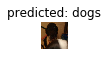

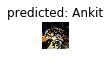

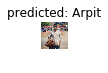

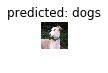

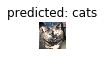

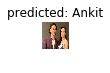

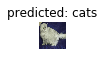

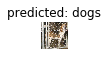

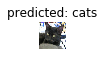

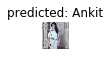

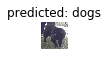

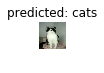

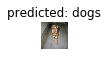

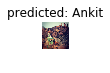

In [147]:
visualize_model(model_ft)

In [90]:
model_ft.training

False